## 1. Business Understanding

### 1.1 Overview

>Online shopping refers to a delivery and pick-up service. This particular service  is offered by companies through a website and mobile app. The service allows customers to order items from participating retailers with the shopping being done by a personal shopper or company. 

>Covid-19 has changed the way the world operates. The ‘new normal’ has also seen dramatic increases in online shopping trends for apparent reasons. Contactless transactions are safer, and lockdowns have given people no choice but to use online platforms to purchase goods. As you know, however, don’t last forever. Still, once a customer has experienced the convenience and safety of an initially obligated online shopping experience, they are very likely to use it again even when they don’t have to.

>Some of the advantages of online shopping include; there are a variety of products, it's covenient, there are a lot of online discounts, there is buyer/shopping secrecy, the customers can avoid crowds, you can find unique/rare products and there is detailed information about the products that you are buying.

>To effect some of these advantages of online shopping a recommendation system or recommendation engine can be used for information filtering where it tries to predict the preferences of a user and provide suggestions based on these preferences. 


### 1.2 Business Objectives

>1. To particularly provide product recommendations and to look for unique ways to personalize marketing to customer base.

>2. To determine the month with the highest sales so as to plan the optimal time to give discounts

>3. To determine the peak hours of the day inorder to better strategize our marketing through online ads.


### 1.3 Determining The Project Goals

- To obtain a prediction for a specific user for a particular item 

- Introduce a new user with quantity to quantity matrix and make recommendations for them 

- Create a function that will return the top n recommendations for a user . 

### 1.4 Determining the project success criteria 

>1. MAE

>2. RSME

## 2. Data Understanding

### 2.1 Collecting Data

In [193]:
#import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats

#Modeling
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from sklearn.metrics.pairwise import cosine_similarity

In [194]:
#Loading Data and previewing the first five rows
df = pd.read_csv('data.csv',encoding= 'unicode_escape')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### 2.2 Describing the data

In [195]:
#Data Description
Description = pd.read_csv('data_description.csv',header=0,squeeze=True,dtype=str,keep_default_na=False,encoding='unicode_escape')

Description

,Column_Name,Description
0,InvoiceNo,"Invoice number. Nominal, a 6-digit integral n..."
1,StockCode,"Product (item) code. Nominal, a 5-digit integ..."
2,Description,Product (item) name. Nominal.
3,Quantity,The quantities of each product (item) per tra...
4,InvoiceDate,"Invoice Date and time. Numeric, the day and t..."
5,UnitPrice,"Unit price. Numeric, Product price per unit i..."
6,CustomerID,"Customer number. Nominal, a 5-digit integral ..."
7,Country,"Country name. Nominal, the name of the countr..."


In [196]:
#Looking at the shape of the data
df.shape

(541909, 8)

There are 541,909 rows and 8 columns in this data set

In [197]:
#looking at the information of the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [198]:
# Summary statistics of the data set
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [199]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [200]:
df.duplicated().sum()

5268

## 3. Data Preparation

### 3.1 Creating a new data frame

#### 3.1.1 Splitting the date 

In [201]:
# Spliting the date to years, months, day and time
df['Month'] = df['InvoiceDate'].apply(lambda x : x.split('/')[0]).astype(np.uint8)
df['Day'] = df['InvoiceDate'].apply(lambda x : x.split('/')[1]).astype(np.uint8)
df['Year'] = df['InvoiceDate'].apply(lambda x : x.split('/')[2].split(' ')[0]).astype(np.uint16)
df['Time'] = df['InvoiceDate'].apply(lambda x : x.split('/')[2].split(' ')[1])
df['Hour']= df['Time'].apply(lambda x : x.split(':')[0]).astype(np.uint8)
df['Min']= df['Time'].apply(lambda x : x.split(':')[1]).astype(np.uint8)
df['datetime'] = list(map(lambda x : datetime.date(x[0],x[1],x[2]),df[['Year','Month','Day']].values) )
df['Day_week'] = list(map(lambda x :x.weekday(),df['datetime'].values)) # datetime.date(2017,12,25)
df['Day_week'] = df['Day_week'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thur',4:'Fri',5:'Sat',6:'Sun'})
df = df.sort_values('datetime')

df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Day,Year,Time,Hour,Min,datetime,Day_week
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,12,1,2010,8:26,8,26,2010-12-01,Wed
2066,536557,84029E,RED WOOLLY HOTTIE WHITE HEART.,1,12/1/2010 14:41,3.75,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,Wed
2067,536557,22678,FRENCH BLUE METAL DOOR SIGN 3,3,12/1/2010 14:41,1.25,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,Wed
2068,536557,22686,FRENCH BLUE METAL DOOR SIGN No,1,12/1/2010 14:41,1.25,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,Wed
2069,536557,22468,BABUSHKA LIGHTS STRING OF 10,1,12/1/2010 14:41,6.75,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,Wed


#### 3.1.2 Adding Total Cost Column

In [202]:
# Calculating the total cost per order
df['Total_Amount'] = df['Quantity']*df['UnitPrice']
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Day,Year,Time,Hour,Min,datetime,Day_week,Total_Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,12,1,2010,8:26,8,26,2010-12-01,Wed,15.30
2066,536557,84029E,RED WOOLLY HOTTIE WHITE HEART.,1,12/1/2010 14:41,3.75,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,Wed,3.75
2067,536557,22678,FRENCH BLUE METAL DOOR SIGN 3,3,12/1/2010 14:41,1.25,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,Wed,3.75
2068,536557,22686,FRENCH BLUE METAL DOOR SIGN No,1,12/1/2010 14:41,1.25,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,Wed,1.25
2069,536557,22468,BABUSHKA LIGHTS STRING OF 10,1,12/1/2010 14:41,6.75,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,Wed,6.75


In [203]:
#New data info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541909 entries, 0 to 541908
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     541909 non-null  object 
 1   StockCode     541909 non-null  object 
 2   Description   540455 non-null  object 
 3   Quantity      541909 non-null  int64  
 4   InvoiceDate   541909 non-null  object 
 5   UnitPrice     541909 non-null  float64
 6   CustomerID    406829 non-null  float64
 7   Country       541909 non-null  object 
 8   Month         541909 non-null  uint8  
 9   Day           541909 non-null  uint8  
 10  Year          541909 non-null  uint16 
 11  Time          541909 non-null  object 
 12  Hour          541909 non-null  uint8  
 13  Min           541909 non-null  uint8  
 14  datetime      541909 non-null  object 
 15  Day_week      541909 non-null  object 
 16  Total_Amount  541909 non-null  float64
dtypes: float64(3), int64(1), object(8), uint16(1), u

In [204]:
#New data shape
df.shape

(541909, 17)

In [205]:
#New data set first 5 rows
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Day,Year,Time,Hour,Min,datetime,Day_week,Total_Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,12,1,2010,8:26,8,26,2010-12-01,Wed,15.30
2066,536557,84029E,RED WOOLLY HOTTIE WHITE HEART.,1,12/1/2010 14:41,3.75,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,Wed,3.75
2067,536557,22678,FRENCH BLUE METAL DOOR SIGN 3,3,12/1/2010 14:41,1.25,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,Wed,3.75
2068,536557,22686,FRENCH BLUE METAL DOOR SIGN No,1,12/1/2010 14:41,1.25,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,Wed,1.25
2069,536557,22468,BABUSHKA LIGHTS STRING OF 10,1,12/1/2010 14:41,6.75,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,Wed,6.75


### 3.2 Cleaning the Data

#### 3.2.1 Duplicates

In [206]:
#Looking at the duplicates in the data set

df.duplicated().sum()/len(df)*100

0.9721189350979592

In [207]:
#Dropping the duplicates from the data set
df = df.drop_duplicates()
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Day,Year,Time,Hour,Min,datetime,Day_week,Total_Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,12,1,2010,8:26,8,26,2010-12-01,Wed,15.30
2066,536557,84029E,RED WOOLLY HOTTIE WHITE HEART.,1,12/1/2010 14:41,3.75,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,Wed,3.75
2067,536557,22678,FRENCH BLUE METAL DOOR SIGN 3,3,12/1/2010 14:41,1.25,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,Wed,3.75
2068,536557,22686,FRENCH BLUE METAL DOOR SIGN No,1,12/1/2010 14:41,1.25,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,Wed,1.25
2069,536557,22468,BABUSHKA LIGHTS STRING OF 10,1,12/1/2010 14:41,6.75,17841.0,United Kingdom,12,1,2010,14:41,14,41,2010-12-01,Wed,6.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540815,581492,22358,KINGS CHOICE TEA CADDY,1,12/9/2011 10:03,5.79,NaN,United Kingdom,12,9,2011,10:03,10,3,2011-12-09,Fri,5.79
540814,581492,22357,KINGS CHOICE BISCUIT TIN,2,12/9/2011 10:03,4.13,NaN,United Kingdom,12,9,2011,10:03,10,3,2011-12-09,Fri,8.26
540813,581492,22356,CHARLOTTE BAG PINK POLKADOT,1,12/9/2011 10:03,1.63,NaN,United Kingdom,12,9,2011,10:03,10,3,2011-12-09,Fri,1.63
540823,581492,85038,6 CHOCOLATE LOVE HEART T-LIGHTS,1,12/9/2011 10:03,4.13,NaN,United Kingdom,12,9,2011,10:03,10,3,2011-12-09,Fri,4.13


In [208]:
# Checking for duplicates after droping the duplicates
df.duplicated().sum()/len(df)*100

0.0

#### 3.2.2 Missing Values Treatment

Missing data in the E-commerce data set can reduce the power / fit of a model or can lead to a biased model because we have not analysed the behavior and relationship with other variables correctly. It can lead to wrong prediction or classification.

In [209]:
# Sum of missing values as a percentage
df.isnull().sum()/len(df)* 100

InvoiceNo        0.000000
StockCode        0.000000
Description      0.270945
Quantity         0.000000
InvoiceDate      0.000000
UnitPrice        0.000000
CustomerID      25.163377
Country          0.000000
Month            0.000000
Day              0.000000
Year             0.000000
Time             0.000000
Hour             0.000000
Min              0.000000
datetime         0.000000
Day_week         0.000000
Total_Amount     0.000000
dtype: float64

In [210]:
#Checking the top 10 missing values
df1 = df[df.isna().any(axis=1)]

df1.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Day,Year,Time,Hour,Min,datetime,Day_week,Total_Amount
2102,536558,22802,FAUX FUR CHOCOLATE THROW,5,12/1/2010 14:48,19.95,NaN,United Kingdom,12,1,2010,14:48,14,48,2010-12-01,Wed,99.75
1969,536544,21758,VINTAGE SHELLS PRINT,1,12/1/2010 14:32,12.72,NaN,United Kingdom,12,1,2010,14:32,14,32,2010-12-01,Wed,12.72
1970,536545,21134,NaN,1,12/1/2010 14:32,0.00,NaN,United Kingdom,12,1,2010,14:32,14,32,2010-12-01,Wed,0.00
1971,536546,22145,NaN,1,12/1/2010 14:33,0.00,NaN,United Kingdom,12,1,2010,14:33,14,33,2010-12-01,Wed,0.00
1972,536547,37509,NaN,1,12/1/2010 14:33,0.00,NaN,United Kingdom,12,1,2010,14:33,14,33,2010-12-01,Wed,0.00
1968,536544,21742,LARGE ROUND WICKER PLATTER,1,12/1/2010 14:32,12.72,NaN,United Kingdom,12,1,2010,14:32,14,32,2010-12-01,Wed,12.72
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.00,NaN,United Kingdom,12,1,2010,14:34,14,34,2010-12-01,Wed,0.00
1988,536550,85044,NaN,1,12/1/2010 14:34,0.00,NaN,United Kingdom,12,1,2010,14:34,14,34,2010-12-01,Wed,0.00
1967,536544,21731,RED TOADSTOOL LED NIGHT LIGHT,5,12/1/2010 14:32,3.36,NaN,United Kingdom,12,1,2010,14:32,14,32,2010-12-01,Wed,16.80
1965,536544,21721,CANDY SHOP STICKER SHEET,1,12/1/2010 14:32,1.66,NaN,United Kingdom,12,1,2010,14:32,14,32,2010-12-01,Wed,1.66


In [211]:
#checking the distribution of the data in 2010 and 2011
df['Year'].value_counts()/len(df)

2011    0.921771
2010    0.078229
Name: Year, dtype: float64

A large percentage of the data set is from 2011

In [212]:
# Checking the months with the highest missing values in 2011
df_2011 = df1.loc[lambda df1: df1["Year"]==2011]
df_2011['Month'].value_counts()[:20]

11    19111
1     13230
7     12011
10    10041
9      9402
6      9033
3      8923
5      8121
12     7864
8      7620
2      7341
4      6713
Name: Month, dtype: int64

From this analysis we can see that the missing values in 2011 are more during November, January, July and October.

In [213]:
#checking the months with the highest missing value in 2010
df_2010 = df1.loc[lambda df1: df1["Year"]==2010]
df_2010['Month'].value_counts()[:20]

12    15627
Name: Month, dtype: int64

In [214]:
df['Year'].value_counts()

2011    494660
2010     41981
Name: Year, dtype: int64

In [215]:
# Dropping all the null values in the data set
df=df.dropna()
df.isnull().sum()/len(df)* 100

InvoiceNo       0.0
StockCode       0.0
Description     0.0
Quantity        0.0
InvoiceDate     0.0
UnitPrice       0.0
CustomerID      0.0
Country         0.0
Month           0.0
Day             0.0
Year            0.0
Time            0.0
Hour            0.0
Min             0.0
datetime        0.0
Day_week        0.0
Total_Amount    0.0
dtype: float64

#### 3.2.3 Outliers

Outliers in the Ecommerce data set can drastically change the results of the data analysis and statistical modeling. There are numerous unfavourable impacts of outliers in the data set:

It increases the error variance and reduces the power of statistical tests

If the outliers are non-randomly distributed, they can decrease normality

They can bias or influence estimates that may be of substantive interest

They can also impact the basic assumption of Regression, ANOVA and other statistical model assumptions.

In this case we will use boxplots to identify the outliers.

##### 3.2.3.1 Unit Price

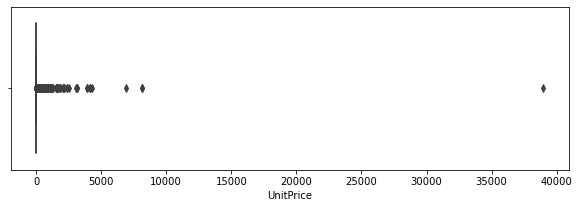

In [216]:
# identify the price outliers
plt.figure(figsize=(10,3))

sns.boxplot(x = 'UnitPrice', data = df)

# Display the plot
plt.show()

In [217]:
i = df[(df['UnitPrice']>10000)].index

df = df.drop(i)

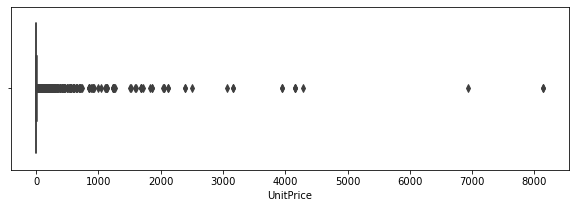

In [218]:
# identify the price outliers after removing the outliers
plt.figure(figsize=(10,3))

sns.boxplot(x = 'UnitPrice', data = df)

# Display the plot
plt.show()

##### 3.2.3.2 Quantity

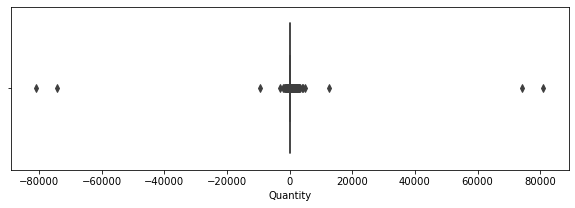

In [219]:
# identify the quantity outliers
plt.figure(figsize=(10,3))

sns.boxplot(x = 'Quantity', data = df)

# Display the plot
plt.show()

In [220]:
i = df[(df['Quantity']>18000)].index

k = df[(df['Quantity']<-15000)].index

df = df.drop(i)
df = df.drop(k)

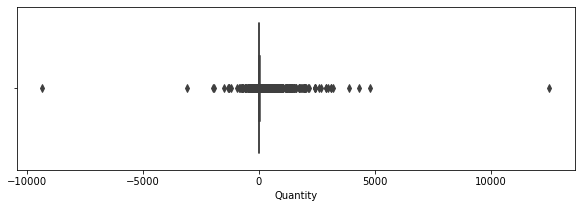

In [221]:
# identify the quantity outliers
plt.figure(figsize=(10,3))

sns.boxplot(x = 'Quantity', data = df)

# Display the plot
plt.show()

### 3.3.Exploratory Data Analysis

### 3.3.1.Univariate Analysis

#### 3.3.1.1. Orders

In [222]:

orders = df.groupby(by=['CustomerID'], as_index=False)['Quantity'].sum().sort_values(by='Quantity', ascending=False)

orders.head(10)

,CustomerID,Quantity
1702,14646.0,196719
54,12415.0,77242
1894,14911.0,77155
3757,17450.0,69009
4232,18102.0,64122
3800,17511.0,63012
1004,13694.0,61899
1446,14298.0,58021
1344,14156.0,56908
3201,16684.0,49390


#### 3.3.1.2. Country

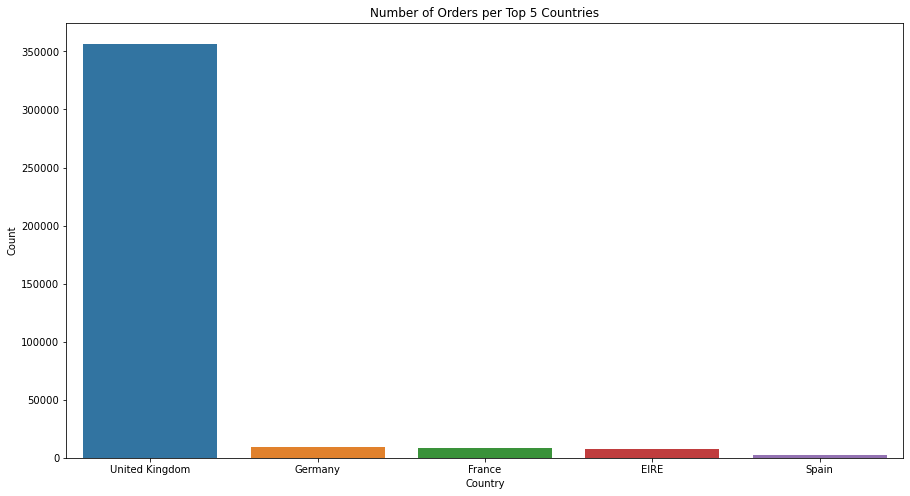

In [223]:
#Orders count plot
plt.figure(figsize=(15,8))

sns.countplot(x='Country', data= df, order=df['Country'].value_counts().iloc[:5].index)
plt.title('Number of Orders per Top 5 Countries')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

#### 3.3.1.3. Months

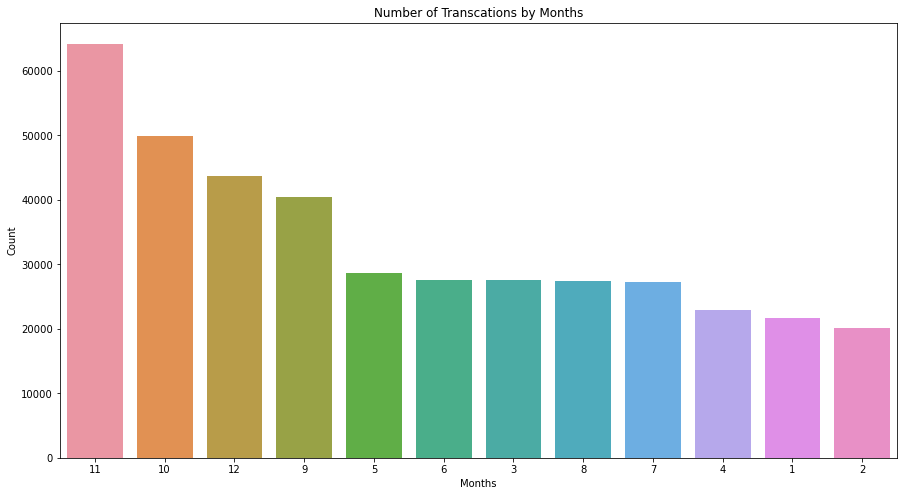

In [224]:
#Months count plot
plt.figure(figsize=(15,8))

sns.countplot(x='Month', data= df, order=df['Month'].value_counts().index)
plt.title('Number of Transcations by Months')
plt.xlabel('Months')
plt.ylabel('Count')
plt.show()

#### 3.3.1.4. Time of Day

In [225]:
def get_time(Hour):
    if Hour < 12:
         return 'Morning'
    if Hour > 12 and Hour < 16:
        return 'Afternoon'
    else:
        return 'Evening'

In [226]:
df['time_day']=df['Hour'].apply(get_time)
df['time_day'].value_counts()

Afternoon    163885
Morning      119905
Evening      117809
Name: time_day, dtype: int64

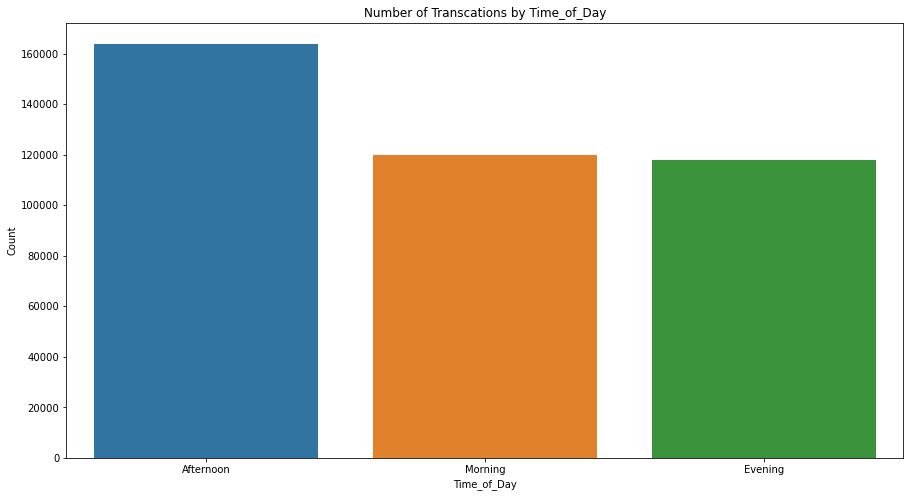

In [227]:
#Months count plot
plt.figure(figsize=(15,8))

sns.countplot(x='time_day', data= df, order=df['time_day'].value_counts().index)
plt.title('Number of Transcations by Time_of_Day')
plt.xlabel('Time_of_Day')
plt.ylabel('Count')
plt.show()

#### 3.3.1.5. Day of the Week

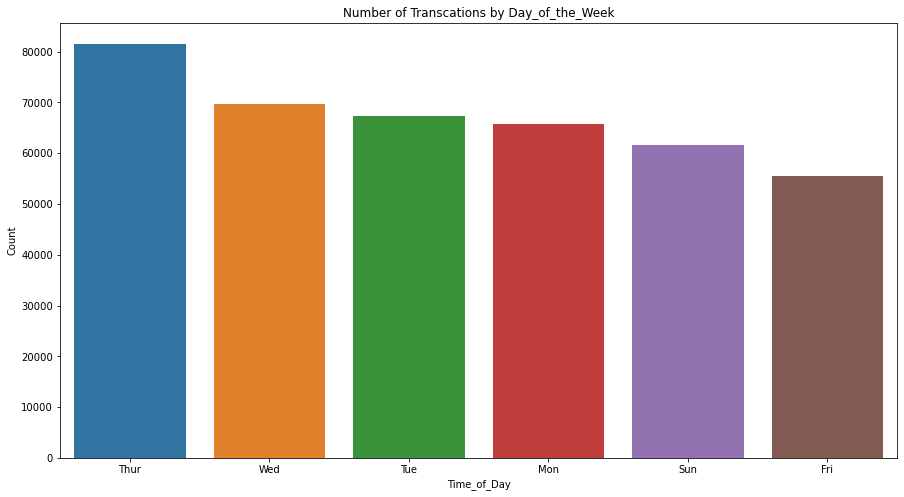

In [228]:
#Months count plot
plt.figure(figsize=(15,8))

sns.countplot(x='Day_week', data= df, order=df['Day_week'].value_counts().index)
plt.title('Number of Transcations by Day_of_the_Week')
plt.xlabel('Time_of_Day')
plt.ylabel('Count')
plt.show()

#### 3.3.1.5. Time

### 3.3.2.Bivariate Analysis

#### 3.3.2.1 Total Amount vs Customer ID

#### 3.3.2.2 Total Amount vs Country

#### 3.3.2.3 Number of Orders per Day

#### 3.3.2.4 Number of Orders per Month

#### 3.3.2.5 Number of Orders per Customer per Country

In [229]:
Top_customer_orders = df.groupby(by=['CustomerID','Country'], as_index=False)['Quantity'].sum().sort_values(by='Quantity', ascending=False)

Top_customer_orders .head(10)

,CustomerID,Country,Quantity
1710,14646.0,Netherlands,196719
56,12415.0,Australia,77242
1902,14911.0,EIRE,77155
3765,17450.0,United Kingdom,69009
4240,18102.0,United Kingdom,64122
3808,17511.0,United Kingdom,63012
1012,13694.0,United Kingdom,61899
1454,14298.0,United Kingdom,58021
1352,14156.0,EIRE,56908
3209,16684.0,United Kingdom,49390


### 3.3.3.Pre-processing of Data

#### 3.3.3.1 Feature Engineering

In [230]:
#Creating a new Data Frame that has a summary of the Total Quantity purchased by a customer
new_df = df.groupby(by=['Description'], as_index=False)['Quantity'].sum().sort_values(by='Quantity', ascending=False)

new_df

,Description,Quantity
3804,WORLD WAR 2 GLIDERS ASSTD DESIGNS,53119
1771,JUMBO BAG RED RETROSPOT,44963
217,ASSORTED COLOUR BIRD ORNAMENT,35215
3715,WHITE HANGING HEART T-LIGHT HOLDER,34128
2279,PACK OF 72 RETROSPOT CAKE CASES,33386
...,...,...
2536,PINK POODLE HANGING DECORATION,-12
882,CRUK Commission,-16
245,ASSORTED TUTTI FRUTTI ROUND BOX,-24
1066,Discount,-1194


In [231]:
# Defining a function that categorizes the quantity demanded by a customer
def get_time(Quantity):
    if Quantity < 0:
         return 1
    elif Quantity < 500:
        return 2
    elif Quantity < 2000:
        return 3
    elif Quantity < 3000:
        return 4
    else:
        return 5

In [232]:
new_df['rating']=new_df['Quantity'].apply(get_time)

new_df['rating'].value_counts()

2    2205
3    1019
5     415
4     229
1      27
Name: rating, dtype: int64

In [233]:
new_df

,Description,Quantity,rating
3804,WORLD WAR 2 GLIDERS ASSTD DESIGNS,53119,5
1771,JUMBO BAG RED RETROSPOT,44963,5
217,ASSORTED COLOUR BIRD ORNAMENT,35215,5
3715,WHITE HANGING HEART T-LIGHT HOLDER,34128,5
2279,PACK OF 72 RETROSPOT CAKE CASES,33386,5
...,...,...,...
2536,PINK POODLE HANGING DECORATION,-12,1
882,CRUK Commission,-16,1
245,ASSORTED TUTTI FRUTTI ROUND BOX,-24,1
1066,Discount,-1194,1


In [234]:
new_df = new_df.drop(columns='Quantity')
new_df

,Description,rating
3804,WORLD WAR 2 GLIDERS ASSTD DESIGNS,5
1771,JUMBO BAG RED RETROSPOT,5
217,ASSORTED COLOUR BIRD ORNAMENT,5
3715,WHITE HANGING HEART T-LIGHT HOLDER,5
2279,PACK OF 72 RETROSPOT CAKE CASES,5
...,...,...
2536,PINK POODLE HANGING DECORATION,1
882,CRUK Commission,1
245,ASSORTED TUTTI FRUTTI ROUND BOX,1
1066,Discount,1


In [235]:
new_df = pd.merge(new_df, df, on = 'Description')

new_df.head(5)

,Description,rating,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Day,Year,Time,Hour,Min,datetime,Day_week,Total_Amount,time_day
0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,5,536839,84077,288,12/2/2010 18:25,0.21,15093.0,United Kingdom,12,2,2010,18:25,18,25,2010-12-02,Thur,60.48,Evening
1,WORLD WAR 2 GLIDERS ASSTD DESIGNS,5,536830,84077,2880,12/2/2010 17:38,0.18,16754.0,United Kingdom,12,2,2010,17:38,17,38,2010-12-02,Thur,518.40,Evening
2,WORLD WAR 2 GLIDERS ASSTD DESIGNS,5,536615,84077,48,12/2/2010 10:09,0.29,14047.0,United Kingdom,12,2,2010,10:09,10,9,2010-12-02,Thur,13.92,Morning
3,WORLD WAR 2 GLIDERS ASSTD DESIGNS,5,536618,84077,48,12/2/2010 10:17,0.29,17017.0,United Kingdom,12,2,2010,10:17,10,17,2010-12-02,Thur,13.92,Morning
4,WORLD WAR 2 GLIDERS ASSTD DESIGNS,5,536856,84077,48,12/3/2010 10:26,0.29,13370.0,United Kingdom,12,3,2010,10:26,10,26,2010-12-03,Fri,13.92,Morning


## 4. Modeling

### 4.1 Collaborative Filtering

>The collaborative filtering method is based on users' previous behaviors, such as the products they bought, or the ratings they gave to different items. The collaborative filtering method uses this data to find similarities between users and recommends the most similar articles or content to users.

>The basic assumption behind the collaborative filtering method is that those who have seen or bought similar content or products in the past are likely to see or buy similar types of content or products in the future.

>Thus, based on this assumption, if one person bought items A, B, and C and another person bought items A, B, and D in the past, it is likely that the first person will buy item D and the other person will buy item C, since they share many similarities with each other

#### 4.1.1 Memory Based (User-User)  - Cosine Similarity

In [236]:
#creating customer matrix of items for the client
customer_item_matrix = df.pivot_table(
    index='CustomerID', 
    columns='Description', 
    values='Quantity',
    aggfunc='sum'
)

customer_item_matrix

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12348.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12349.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12352.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18281.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18282.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [237]:
# changing the customer_item_matrix to '0''and '1'
customer_item_matrix = customer_item_matrix.applymap(lambda x: 1 if x > 0 else 0)

customer_item_matrix

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12349.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12352.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18281.0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
18282.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 4.1.2 Cosine Similarity between the Customers

In [238]:
#use the customer_item_matrix to calculate the cosine between the customers
user_user_sim_matrix = pd.DataFrame(
    cosine_similarity(customer_item_matrix)
)

In [239]:
#change the user_user_matrix index to match the cutomer Index
user_user_sim_matrix.columns = customer_item_matrix.index

user_user_sim_matrix

CustomerID,12347.0,12348.0,12349.0,12350.0,12352.0,12353.0,12354.0,12355.0,12356.0,12357.0,...,18273.0,18274.0,18276.0,18277.0,18278.0,18280.0,18281.0,18282.0,18283.0,18287.0
0,1.000000,0.063022,0.046130,0.047795,0.038814,0.0,0.012938,0.136641,0.094742,0.060262,...,0.0,0.0,0.054656,0.000000,0.032844,0.062318,0.000000,0.113776,0.101565,0.012828
1,0.063022,1.000000,0.024953,0.051709,0.027995,0.0,0.027995,0.118262,0.146427,0.000000,...,0.0,0.0,0.118262,0.000000,0.000000,0.000000,0.000000,0.000000,0.168053,0.083269
2,0.046130,0.024953,1.000000,0.056773,0.122946,0.0,0.030737,0.032461,0.144692,0.153389,...,0.0,0.0,0.000000,0.000000,0.039014,0.000000,0.000000,0.067574,0.113547,0.015237
3,0.047795,0.051709,0.056773,1.000000,0.031846,0.0,0.000000,0.000000,0.033315,0.021190,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044118,0.000000
4,0.038814,0.027995,0.122946,0.031846,1.000000,0.0,0.103448,0.036418,0.090182,0.057361,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.037905,0.071655,0.034189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4366,0.062318,0.000000,0.000000,0.000000,0.000000,0.0,0.041523,0.000000,0.000000,0.055258,...,0.0,0.0,0.000000,0.000000,0.105409,1.000000,0.119523,0.000000,0.000000,0.000000
4367,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.049629,0.000000,0.000000,0.066046,...,0.0,0.0,0.000000,0.000000,0.000000,0.119523,1.000000,0.000000,0.045835,0.000000
4368,0.113776,0.000000,0.067574,0.000000,0.037905,0.0,0.000000,0.160128,0.079305,0.025222,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.017504,0.000000
4369,0.101565,0.168053,0.113547,0.044118,0.071655,0.0,0.111463,0.033634,0.091616,0.074167,...,0.0,0.0,0.016817,0.042875,0.000000,0.000000,0.045835,0.017504,1.000000,0.094726


In [240]:
#changing the data index to CustomerID
user_user_sim_matrix['CustomerID'] = customer_item_matrix.index
user_user_sim_matrix = user_user_sim_matrix.set_index('CustomerID')
user_user_sim_matrix 

CustomerID,12347.0,12348.0,12349.0,12350.0,12352.0,12353.0,12354.0,12355.0,12356.0,12357.0,...,18273.0,18274.0,18276.0,18277.0,18278.0,18280.0,18281.0,18282.0,18283.0,18287.0
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,1.000000,0.063022,0.046130,0.047795,0.038814,0.0,0.012938,0.136641,0.094742,0.060262,...,0.0,0.0,0.054656,0.000000,0.032844,0.062318,0.000000,0.113776,0.101565,0.012828
12348.0,0.063022,1.000000,0.024953,0.051709,0.027995,0.0,0.027995,0.118262,0.146427,0.000000,...,0.0,0.0,0.118262,0.000000,0.000000,0.000000,0.000000,0.000000,0.168053,0.083269
12349.0,0.046130,0.024953,1.000000,0.056773,0.122946,0.0,0.030737,0.032461,0.144692,0.153389,...,0.0,0.0,0.000000,0.000000,0.039014,0.000000,0.000000,0.067574,0.113547,0.015237
12350.0,0.047795,0.051709,0.056773,1.000000,0.031846,0.0,0.000000,0.000000,0.033315,0.021190,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044118,0.000000
12352.0,0.038814,0.027995,0.122946,0.031846,1.000000,0.0,0.103448,0.036418,0.090182,0.057361,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.037905,0.071655,0.034189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0.062318,0.000000,0.000000,0.000000,0.000000,0.0,0.041523,0.000000,0.000000,0.055258,...,0.0,0.0,0.000000,0.000000,0.105409,1.000000,0.119523,0.000000,0.000000,0.000000
18281.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.049629,0.000000,0.000000,0.066046,...,0.0,0.0,0.000000,0.000000,0.000000,0.119523,1.000000,0.000000,0.045835,0.000000
18282.0,0.113776,0.000000,0.067574,0.000000,0.037905,0.0,0.000000,0.160128,0.079305,0.025222,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.017504,0.000000


#### 4.1.3 Testing The Cosine Similarity

##### 4.1.3.1 Top 5 Customers

In [241]:
Top_customer_orders.head()

,CustomerID,Country,Quantity
1710,14646.0,Netherlands,196719
56,12415.0,Australia,77242
1902,14911.0,EIRE,77155
3765,17450.0,United Kingdom,69009
4240,18102.0,United Kingdom,64122


##### 4.1.3.2 Similar Customers to our Top Customer

In [242]:
#Similar customers to our top customer (CustomerID - 14646)

user_user_sim_matrix.loc[14646].sort_values(ascending=False)

CustomerID
14646.0    1.000000
14911.0    0.467512
12415.0    0.451567
12748.0    0.445622
17841.0    0.425535
             ...   
16856.0    0.000000
13132.0    0.000000
13135.0    0.000000
13145.0    0.000000
13832.0    0.000000
Name: 14646.0, Length: 4371, dtype: float64

The most similar customers to our top customer is cutomer with CustomerID **(14911, 12415)**

##### 4.1.3.3 Product Recommendation

Steps:

>First, we need to identify the items that Customers with CustomerID **14646** and **12415** have already purchased.

>Then, let's find the products that target client **12415** has not purchased, but client **14646** has.

>Since these two customers have bought similar items in the past, we will assume that target customer **12415** has a high probability of buying the items he or she has not bought, but customer **14646** has.

>Finally, we are going to use this list of items and recommend them to target customer  **12415**.

>Let's first see how we can retrieve the items that the **14646** customer has purchased in the past. 

In [243]:
#Items bought by customer 14646

items_bought_by_A = set(customer_item_matrix.loc[14646].iloc[
    customer_item_matrix.loc[14646].to_numpy().nonzero()
].index)

items_bought_by_A

{' DOLLY GIRL BEAKER',
 ' I LOVE LONDON MINI BACKPACK',
 ' I LOVE LONDON MINI RUCKSACK',
 ' SPACEBOY BABY GIFT SET',
 '10 COLOUR SPACEBOY PEN',
 '12 PENCIL SMALL TUBE WOODLAND',
 '12 PENCILS SMALL TUBE RED RETROSPOT',
 '12 PENCILS TALL TUBE RED RETROSPOT',
 '12 PENCILS TALL TUBE WOODLAND',
 '16 PIECE CUTLERY SET PANTRY DESIGN',
 '20 DOLLY PEGS RETROSPOT',
 '200 RED + WHITE BENDY STRAWS',
 '3 HEARTS HANGING DECORATION RUSTIC',
 '3 HOOK HANGER MAGIC GARDEN',
 '3 PIECE SPACEBOY COOKIE CUTTER SET',
 '3 STRIPEY MICE FELTCRAFT',
 '36 FOIL HEART CAKE CASES',
 '36 FOIL STAR CAKE CASES ',
 '36 PENCILS TUBE RED RETROSPOT',
 '36 PENCILS TUBE WOODLAND',
 '3D CHRISTMAS STAMPS STICKERS ',
 '3D HEARTS  HONEYCOMB PAPER GARLAND',
 '5 HOOK HANGER MAGIC TOADSTOOL',
 '5 HOOK HANGER RED MAGIC TOADSTOOL',
 '6 RIBBONS RUSTIC CHARM',
 '60 CAKE CASES DOLLY GIRL DESIGN',
 '60 CAKE CASES VINTAGE CHRISTMAS',
 '60 TEATIME FAIRY CAKE CASES',
 '72 SWEETHEART FAIRY CAKE CASES',
 'ABC TREASURE BOOK BOX ',
 'ALARM CLOC

In [244]:
#Items bought by customer 12415
items_bought_by_B = set(customer_item_matrix.loc[12415].iloc[
    customer_item_matrix.loc[12415].to_numpy().nonzero()
].index)
items_bought_by_B 

{' DOLLY GIRL BEAKER',
 '10 COLOUR SPACEBOY PEN',
 '12 PENCIL SMALL TUBE WOODLAND',
 '12 PENCILS TALL TUBE POSY',
 '16 PIECE CUTLERY SET PANTRY DESIGN',
 '3 STRIPEY MICE FELTCRAFT',
 '3 TIER CAKE TIN GREEN AND CREAM',
 '3 TIER CAKE TIN RED AND CREAM',
 '36 DOILIES VINTAGE CHRISTMAS',
 '36 PENCILS TUBE RED RETROSPOT',
 '36 PENCILS TUBE SKULLS',
 '4 TRADITIONAL SPINNING TOPS',
 '6 GIFT TAGS VINTAGE CHRISTMAS ',
 '6 RIBBONS RUSTIC CHARM',
 '60 CAKE CASES VINTAGE CHRISTMAS',
 "70'S ALPHABET WALL ART",
 '72 SWEETHEART FAIRY CAKE CASES',
 'ABC TREASURE BOOK BOX ',
 'ALARM CLOCK BAKELIKE CHOCOLATE',
 'ALARM CLOCK BAKELIKE GREEN',
 'ALARM CLOCK BAKELIKE IVORY',
 'ALARM CLOCK BAKELIKE PINK',
 'ALARM CLOCK BAKELIKE RED ',
 'ANIMALS AND NATURE WALL ART',
 'ASSORTED COLOURS SILK FAN',
 'ASSORTED EASTER GIFT TAGS',
 'BAKING MOULD EASTER EGG MILK CHOC',
 'BAKING MOULD EASTER EGG WHITE CHOC',
 'BAKING SET 9 PIECE RETROSPOT ',
 'BAKING SET SPACEBOY DESIGN',
 'BICYCLE SAFTEY WALL ART',
 'BINGO SET',
 "

In [245]:
items_to_recommend_to_B = items_bought_by_A - items_bought_by_B
items_to_recommend_to_B

{' I LOVE LONDON MINI BACKPACK',
 ' I LOVE LONDON MINI RUCKSACK',
 ' SPACEBOY BABY GIFT SET',
 '12 PENCILS SMALL TUBE RED RETROSPOT',
 '12 PENCILS TALL TUBE RED RETROSPOT',
 '12 PENCILS TALL TUBE WOODLAND',
 '20 DOLLY PEGS RETROSPOT',
 '200 RED + WHITE BENDY STRAWS',
 '3 HEARTS HANGING DECORATION RUSTIC',
 '3 HOOK HANGER MAGIC GARDEN',
 '3 PIECE SPACEBOY COOKIE CUTTER SET',
 '36 FOIL HEART CAKE CASES',
 '36 FOIL STAR CAKE CASES ',
 '36 PENCILS TUBE WOODLAND',
 '3D CHRISTMAS STAMPS STICKERS ',
 '3D HEARTS  HONEYCOMB PAPER GARLAND',
 '5 HOOK HANGER MAGIC TOADSTOOL',
 '5 HOOK HANGER RED MAGIC TOADSTOOL',
 '60 CAKE CASES DOLLY GIRL DESIGN',
 '60 TEATIME FAIRY CAKE CASES',
 'ANGEL DECORATION PAINTED ZINC ',
 'APOTHECARY MEASURING JAR',
 'APRON APPLE DELIGHT',
 'ASSORTED COLOUR BIRD ORNAMENT',
 'ASSORTED EASTER DECORATIONS  BELLS',
 'ASSORTED FLOWER COLOUR "LEIS"',
 'ASSORTED TUTTI FRUTTI  FOB NOTEBOOK',
 'ASSTD FRUIT+FLOWERS FRIDGE MAGNETS',
 'BAKING MOULD HEART WHITE CHOCOLATE',
 'BAKING M

Using user-based collaborative filtering, we have seen how we can make specific product recommendations for individual customers. You can customize and include in your marketing messages these products that each target customer is likely to buy, which can generate more conversions from your customers.  As we have seen in this exercise, recommendations are based on the individual customer's purchase history.

#### 4.1.2 Collaborative Filtering - Surprise

In [246]:
#Creating new data frame for the model-based approach collaborative filtering

new_df = new_df[['CustomerID', 'Description', 'rating']]

new_df

,CustomerID,Description,rating
0,15093.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,5
1,16754.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,5
2,14047.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,5
3,17017.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,5
4,13370.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,5
...,...,...,...
401594,12955.0,ROTATING SILVER ANGELS T-LIGHT HLDR,1
401595,16442.0,ROTATING SILVER ANGELS T-LIGHT HLDR,1
401596,15311.0,ROTATING SILVER ANGELS T-LIGHT HLDR,1
401597,17581.0,ROTATING SILVER ANGELS T-LIGHT HLDR,1


In [247]:
#Loading the data set
reader = Reader()
data = Dataset.load_from_df(new_df,reader)

In [248]:
# Print the number of users and items
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  4371 

Number of items:  3895


In [261]:
# Split the data into train and test set
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [262]:
# Print the number of users and items
print('Number of users_train: ', trainset.n_users, '\n')
print('Number of items_train: ', trainset.n_items, '\n')


Number of users_train:  4347 

Number of items_train:  3840 



#### 4.1.2.1 Memory_Based Method

In [263]:
#cosine similarity
sim_cos = {'name':'cosine', 'user_based':True}

In [264]:
#fitting our model
basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [253]:
#Looking at the similarity metrics
basic.sim

array([[1., 1., 1., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [265]:
#predicitons made on the test set data
predictions = basic.test(testset)

In [266]:
#accuracy test
print(accuracy.rmse(predictions))

RMSE: 0.0674
0.06739203229526654


#### 4.1.2.2 Model_Based Method

In [267]:
#fitting our model
svd = SVD(n_factors=100, n_epochs=10, lr_all=0.005, reg_all=0.4)
svd.fit(trainset)

#predicitons made on the test set data
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.3952
0.39524988852854664


In [268]:
## Perform a gridsearch with SVD
# ⏰ This cell may take several minutes to run
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)

AttributeError: 'Trainset' object has no attribute 'raw_ratings'